Punto 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

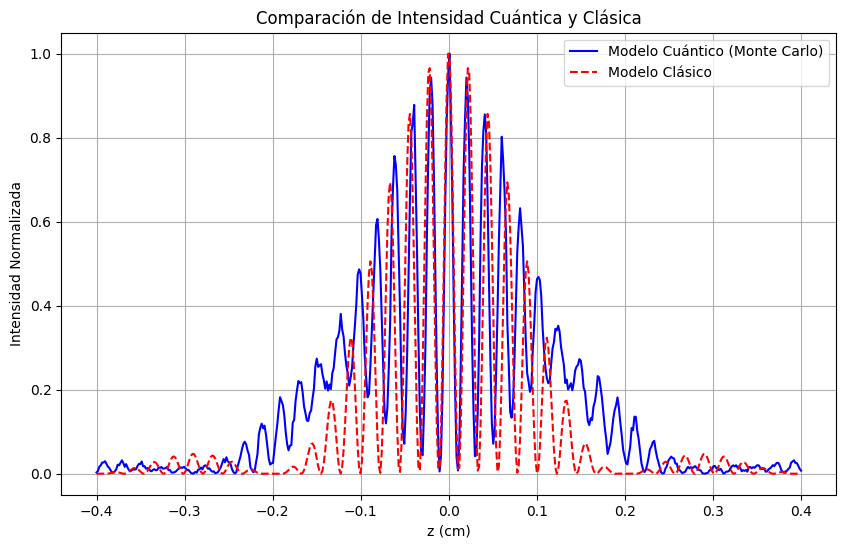

In [2]:
D1 = 30  # cm
D2 = 30  # cm
wavelength = 670e-7  # cm
A = 0.1  # cm
a = 0.01  # cm
d = 0.09  # cm
N = 100000


def monte_carlo_intensity(z):
    x_samples = np.random.uniform(-A/2, A/2, N)
    y = np.random.uniform(d/2, a+d/2, N)
    lista=[-1,1]
    y_samples=y*np.random.choice(lista,len(y))

    phase1 = 2 * np.pi * (D1 + D2) / wavelength
    phase2 = np.pi / (wavelength * D1)
    phase3 = np.pi / (wavelength * D2)

    integrand = np.exp(1j * phase1) * np.exp(1j * phase2 * (x_samples - y_samples)**2) * np.exp(1j * phase3 * (z - y_samples)**2)
    integral_value = np.abs(np.mean(integrand))**2
    return integral_value


z_values = np.linspace(-0.4, 0.4, 500)
quantum_intensity = np.array([monte_carlo_intensity(z) for z in z_values])


theta = np.arctan(z_values / D2)
classic_intensity = np.cos(np.pi * d * np.sin(theta) / wavelength)**2 * np.sinc(a * np.sin(theta) / wavelength)**2


quantum_intensity /= np.max(quantum_intensity)
classic_intensity /= np.max(classic_intensity)


plt.figure(figsize=(10, 6))
plt.plot(z_values, quantum_intensity, label='Modelo Cuántico (Monte Carlo)', color='blue')
plt.plot(z_values, classic_intensity, label='Modelo Clásico', color='red', linestyle='--')
plt.xlabel('z (cm)')
plt.ylabel('Intensidad Normalizada')
plt.title('Comparación de Intensidad Cuántica y Clásica')
plt.legend()
plt.grid(True)
plt.show()


¿Sería posible muestrear la distribución de 𝑦 con Metrópolis-Hastings? Si responde que no, dé razones fuertes. Si responde que sí, hágalo.

Punto 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

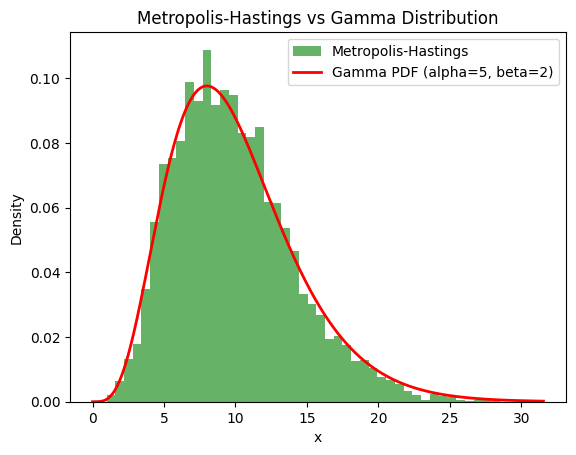

Fitted alpha: 6.222530481699621, Fitted beta: 1.6809443004869613


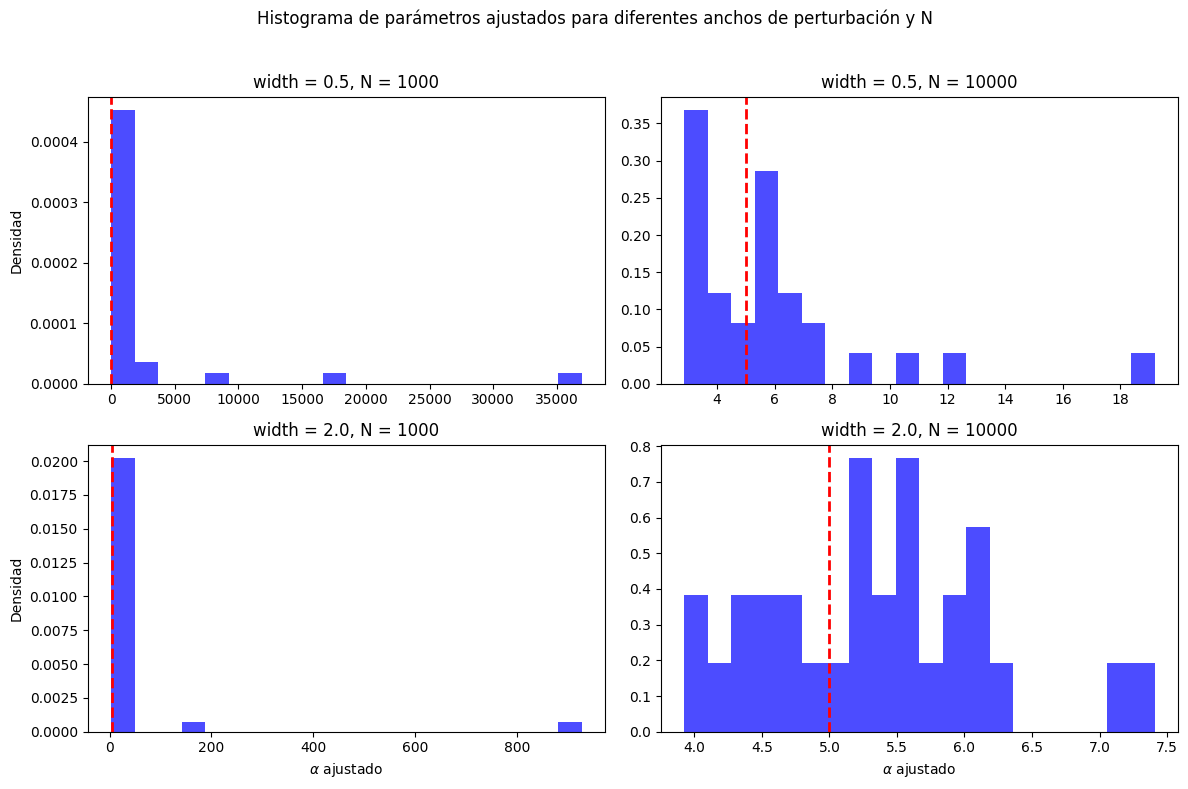

In [ ]:
alpha = 5
beta = 2


def target_distribution(x):
    if x <= 0:
        return 0
    return x**(alpha-1) * np.exp(-x/beta)


def metropolis_hastings(target, num_samples, proposal_width):
    samples = []
    x = np.random.rand() * 10
    for _ in range(num_samples):
        x_proposal = np.random.normal(x, proposal_width)
        acceptance_ratio = target(x_proposal) / target(x)
        if np.random.rand() < acceptance_ratio:
            x = x_proposal
        samples.append(x)
    return np.array(samples)


N = 10_000
proposal_width = 2.0
samples = metropolis_hastings(target_distribution, N, proposal_width)


plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Metropolis-Hastings')


x = np.linspace(0, max(samples), 1000)
plt.plot(x, gamma.pdf(x, alpha, scale=beta), 'r-', lw=2, label=f'Gamma PDF (alpha={alpha}, beta={beta})')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Metropolis-Hastings vs Gamma Distribution')
plt.show()


fitted_params = gamma.fit(samples)
fitted_alpha, fitted_loc, fitted_beta = fitted_params[0], fitted_params[1], fitted_params[2]
print(f"Fitted alpha: {fitted_alpha}, Fitted beta: {fitted_beta}")


num_experiments = 30
proposal_widths = [0.5, 2.0]
N_values = [1000, 10_000]

results = {}

for width in proposal_widths:
    for N in N_values:
        fitted_alphas = []
        fitted_betas = []
        for _ in range(num_experiments):
            samples = metropolis_hastings(target_distribution, N, width)
            fitted_alpha, _, fitted_beta = gamma.fit(samples)
            fitted_alphas.append(fitted_alpha)
            fitted_betas.append(fitted_beta)
        results[(width, N)] = (fitted_alphas, fitted_betas)


fig, axs = plt.subplots(len(proposal_widths), len(N_values), figsize=(12, 8))
fig.suptitle('Histograma de parámetros ajustados para diferentes anchos de perturbación y N')

for i, width in enumerate(proposal_widths):
    for j, N in enumerate(N_values):
        axs[i, j].hist(results[(width, N)][0], bins=20, density=True, alpha=0.7, color='blue', label=r'$\alpha$ ajustado')
        axs[i, j].axvline(alpha, color='red', linestyle='dashed', linewidth=2, label=r'$\alpha$ verdadero')
        axs[i, j].set_title(f'width = {width}, N = {N}')
        if i == len(proposal_widths) - 1:
            axs[i, j].set_xlabel(r'$\alpha$ ajustado')
        if j == 0:
            axs[i, j].set_ylabel('Densidad')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


¿Con qué precisión se recuperan?

Se recuperan los parámetros α y β con bastante precisión, pero existe una dispersión natural debido al muestreo aleatorio.

¿Cambian estos histogramas si cambia el ancho de la distribución de perturbación del Metrópolis?
¿por qué?

Sí, los histogramas cambiarán. El ancho de la distribución de propuesta determina qué tan grandes son las perturbaciones en los valores propuestos. Si el ancho es demasiado pequeño, el algoritmo realizará pasos muy pequeños, lo que puede llevar a una exploración más lenta del espacio de parámetros (efecto de atascamiento en zonas locales). Si el ancho es demasiado grande, el algoritmo podría proponer valores lejanos que tienen muy baja probabilidad, resultando en una alta tasa de rechazo y, nuevamente, en una exploración ineficiente.

Idealmente, quieres un balance donde el ancho sea lo suficientemente grande para explorar el espacio de parámetros, pero no tan grande como para tener muchas propuestas rechazadas.

¿Cambia esto si usa un 𝑁 mayor o menor?
Sí, la precisión mejora con un mayor número de muestras N. Con más muestras, la estimación de la distribución será más precisa, lo que se reflejará en histogramas más concentrados alrededor de los valores verdaderos de 
α y β. Para valores pequeños de N, los histogramas mostrarán una mayor dispersión, indicando que la estimación de los parámetros es menos precisa.

Punto 3. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams["animation.html"] = "jshtml"

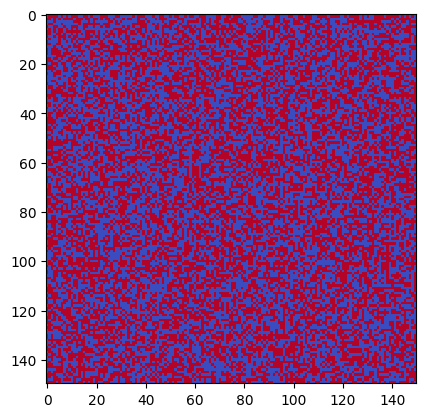

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"

N = 150
J = 0.2
beta = 10
frames = 500
iteraciones_por_frame = 400


espines = np.random.choice([-1, 1], size=(N, N))

def calcular_energia(espines):
    energia = 0
    for i in range(N):
        for j in range(N):
            energia -= J * espines[i, j] * (espines[(i+1) % N, j] + espines[i, (j+1) % N] +
                                            espines[(i-1) % N, j] + espines[i, (j-1) % N])
    return energia


def metropolis(espines):
    i = np.random.randint(0, N)
    j = np.random.randint(0, N)
    
    espines_propuesto = espines.copy()
    espines_propuesto[i, j] *= -1
    
    E_old = calcular_energia(espines)
    E_new = calcular_energia(espines_propuesto)
    delta_E = E_new - E_old
    
    if delta_E <= 0 or np.random.rand() <= np.exp(-beta * delta_E):
        espines[i, j] *= -1
    return espines


fig, ax = plt.subplots()
img = ax.imshow(espines, cmap='coolwarm', interpolation='nearest')

def actualizar(frame):
    global espines
    for _ in range(iteraciones_por_frame):
        espines = metropolis(espines)
    img.set_data(espines)
    return [img]



In [14]:

ani = animation.FuncAnimation(fig, actualizar, frames=frames, blit=True)

ani.save('modelo_ising.gif', fps=30)
ani


MovieWriter ffmpeg unavailable; using Pillow instead.


KeyboardInterrupt: 